In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy.stats as scistats
import statistics as stats
import seaborn as sns

from pathlib import Path



## Libraries, Helper Functions and High Level Variables

In [29]:
dir_path = Path(os.getcwd())
data_dir = str(os.path.join(dir_path,'data'))
balance_files = glob.glob(data_dir + "/poker_balances*.csv")
hands_files = glob.glob(data_dir + "/poker_hands*.csv")
table_files = glob.glob(data_dir + "/poker_table_info*.csv")

def get_hands_df():
    hands_dfs=[]

    for file in hands_files:
        new_df = pd.read_csv(file)
        hands_dfs.append(new_df)

    hands = pd.concat(hands_dfs)
    return hands
    
def get_games_df():
    balance_dfs=[]
    
    for file in balance_files:
        new_df = pd.read_csv(file)
        balance_dfs.append(new_df)
        
    balances = pd.concat(balance_dfs)
    return balances

def get_table_df():
    table_dfs=[]
    
    for file in table_files:
        new_df = pd.read_csv(file)
        table_dfs.append(new_df)
        
    tables = pd.concat(table_dfs)
    return tables


## Getting the Data and Augmentation

In [30]:
pd.set_option('display.max_columns', None)  
hands_base = get_hands_df()
games_base = get_games_df()
tables = get_table_df()

tables['category'] = np.where(tables['scenario_name'].str.startswith('smart'),'smart','conservative')

games = pd.merge(games_base,tables)
hands = pd.merge(hands_base,games)

## Data Samples

We have 3 individual tables: tables, games and hands.  They each represent different types of entities.  This will be explained per table.

### Table 

Our simulation software maps a scenario to a simulation, which in-turn runs a set of 2-6 players over 10 poker tables similar to simulation softwares concept of replications.  Each player within a scenario can have one of 3 personas: Smart Player, Conservative Player or Always Calls Player.  Smart Player runs a 100-card monte-carlo simulation everytime he has to make a betting decision, Conservative player ... and always calls player always calls no matter what happens.  Other types of player personas are implemented, but not used in this analysis.  We decided for this analysis to compare the smart player against the conservative player by having each player play 5 different scenarios against 1,2,3,4 and 5 always call type players. Than compare results between the two of them.  The Tables Dataframe below represents scenario and table level information eg simulation and replication info.

Fields:

* table_id -> replication id representing a poker table
* scenario_name -> represents the name of a simulation
* player_types -> a pipe delimited list of all player personas or types
* category -> if the table is part of the smart or conservative player analysis


In [4]:
tables.head(5)

,table_id,scenario_name,player_types,category
0,1,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
0,10,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
0,100,conservative vs 5 all call player,AlwaysCallPlayer|AlwaysCallPlayer|AlwaysCallPl...,conservative
0,11,smart vs 2 all call player,AlwaysCallPlayer|AlwaysCallPlayer|SmartPlayer,smart
0,12,smart vs 2 all call player,AlwaysCallPlayer|AlwaysCallPlayer|SmartPlayer,smart


### Games

Each table is assigned a French-style poker deck of 52 cards, which it uses to play 100 sequential games of poker with.  It reshuffles the deck after each game.  The balances of the player are carried over between games.  The Games table contains the results of the games and the changes of each players balance as the 100 games progress.  It also records the overall outcome of the player within the game: won/lost and what the final hand would have been (straight, 2-pair, 3-pair etc).  The following information is contained in the Games Data Frame.

Fields:
* table_id -> a relational link to tables data frame representing the table or replication the row is associated with
* game_id -> an id representing one of 100 sequential games for a given table ordered chronologically.
* player_name -> name of the player usually player 1,2,3,4,5,6
* player_type -> the player personal or strategy used during the match
* game_result -> if the player won or lost the round
* game_reason -> did the player win or lose the match during the final hand or did he fold or alternatively was the only person that didn't fodl.
* blind type -> was the player the small or large blind
* beginning balance -> the players balance before joining the table.
* game_start_balance -> the player balance during the start of the poker game
* game_end_balance -> the player balance after the end of the poker game
* game_net_change -> the net change in players balance after the conclusion of the game
* scenario_name -> what scenario it belongs too
* player_types -> what player personas were involved in the game
* category -> what category smart or conservative player analysis dis this game belong to.


In [5]:
games.head(5)

,table_id,game_id,player_name,player_type,game_result,game_reason,blind_type,final_hand,beginning_balance,game_start_balance,game_end_balance,game_net_change,scenario_name,player_types,category
0,1,1,players_1,SmartPlayer,lost,lost_game,small,one_pair,100000,100000.0,99990.0,-10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
1,1,2,players_1,SmartPlayer,won,won_game,big,one_pair,100000,99990.0,100000.0,10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
2,1,3,players_1,SmartPlayer,won,won_game,small,straight,100000,100000.0,100210.0,210.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
3,1,4,players_1,SmartPlayer,lost,fold,big,straight,100000,100210.0,100200.0,-10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
4,1,5,players_1,SmartPlayer,won,won_game,small,full_house,100000,100200.0,100310.0,110.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart


### Hands

Each Game of poker is actually a set of up to 12 betting decisions per player.  3 for pre-flob, 3-card community, 4-card community and 5 card community post-flops.  A player can: call/check, raise or fold the hand.  Each row in the hands dataframe represents one of these betting decisions and provides all the information a player had when making the bet.  It also shows you the result of the bet.  Useful for stepping through the players action during a game.

Fields:
* table_id -> table associated with the bet
* game_id -> game associated with the bet
* player_name -> player name associated with the bet
* player_type -> player persona or strategy used during the bet
* bet_number -> for this specific game_id what bet number this is (1st bet, 2nd bet etc)
* opponents -> number of opponents left
* call -> how much the player needs to call to stay in the game
* current -> how much the player has in the pot right now
* pot -> how large the pot or reward is
* allowed -> if the player was allowed to raise or if it was the last round of bets
* hand1 -> first card in the players hand (of 2)
* hand2 -> the second card in the players hand (of 2)
* community1-5 -> 1-5 community card in the post flop

Everything after these fields are created from a joing to both table and game for convenice.

In [6]:
hands.head(5)

,table_id,game_id,player_name,player_type,bet_number,opponents,call,current,final,pot,allowed,hand1,hand2,community1,community2,community3,community4,community5,game_result,game_reason,blind_type,final_hand,beginning_balance,game_start_balance,game_end_balance,game_net_change,scenario_name,player_types,category
0,1,1,players_1,SmartPlayer,1,1,5,5,10.0,15,True,4-diamonds,Q-diamonds,Z-N/A,Z-N/A,Z-N/A,Z-N/A,Z-N/A,lost,lost_game,small,one_pair,100000,100000.0,99990.0,-10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
1,1,1,players_1,SmartPlayer,2,1,0,10,10.0,20,True,4-diamonds,Q-diamonds,5-clubs,6-hearts,8-spades,Z-N/A,Z-N/A,lost,lost_game,small,one_pair,100000,100000.0,99990.0,-10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
2,1,1,players_1,SmartPlayer,3,1,0,10,10.0,20,True,4-diamonds,Q-diamonds,5-clubs,6-hearts,8-spades,K-spades,Z-N/A,lost,lost_game,small,one_pair,100000,100000.0,99990.0,-10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
3,1,1,players_1,SmartPlayer,4,1,0,10,10.0,20,True,4-diamonds,Q-diamonds,5-clubs,6-hearts,8-spades,K-hearts,K-spades,lost,lost_game,small,one_pair,100000,100000.0,99990.0,-10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart
4,1,2,players_1,SmartPlayer,1,1,0,10,10.0,20,True,J-spades,Q-hearts,Z-N/A,Z-N/A,Z-N/A,Z-N/A,Z-N/A,won,won_game,big,one_pair,100000,99990.0,100000.0,10.0,smart vs 1 all call player,AlwaysCallPlayer|SmartPlayer,smart


# High Level Statistics - All Simulations

We provide a high-level aggregation across all simulations to provide context into the simulation software as a whole.  Since the simulation software is highly configurable, these high level statistics are useful for gauging things like performance or to catch anomalies.

In [7]:
player_final_hands = hands.query('community5 != "Z-N/A"').groupby(['table_id','game_id','player_name','hand1','hand2','community1','community2','community3','community4','community5','final_hand']).count().game_result.reset_index().groupby('final_hand').game_id.count().reset_index()
player_final_hands_type, player_final_hands_type_numbers = list(zip(*player_final_hands.values))
player_final_hands_type = ['player final _hand' + card for card in player_final_hands_type]

winning_hands = games.query('game_result == "won"').groupby(['game_id','final_hand']).count().groupby('final_hand').count().reset_index()[['final_hand','table_id']]
winning_hand_type, winning_hand_type_numbers = list(zip(*winning_hands.values))
winning_hand_type = ['won by ' + card for card in winning_hand_type]

simulation_overview = pd.DataFrame(
    data={
            "Metric":[
                "scenarios",
                "player strategies",
                "active players",
                "player - bet decisions",
                "tables",
                "games", 
                "average chip gain/loss",
                "average pot size",
                "unique 2-card combos",
                "unique end combos",
                "unique 3-card flops",
                "unique 4-card flops",
                "unique 5-card flops"
            ] + list(player_final_hands_type) +
                list(winning_hand_type),
            "Total":[
                tables.scenario_name.nunique(),
                games.player_type.nunique(),
                games.groupby(['table_id','player_name']).game_result.count().reset_index().shape[0],
                hands.shape[0],
                tables.table_id.nunique(),
                games.game_id.nunique(),
                round(games.game_net_change.mean(),0),
                round(hands.pot.mean(),0),
                hands.groupby(['hand1','hand2']).count().reset_index().shape[0],
                hands.query('community5 != "Z-N/A"').groupby(['hand1','hand2','community1','community2','community3','community4','community5']).count().reset_index().shape[0],
                hands.query('community1 != "Z-N/A"').groupby(['community1','community2','community3']).count().reset_index().shape[0],
                hands.query('community4 != "Z-N/A"').groupby(['community1','community2','community3','community4']).count().reset_index().shape[0],
                hands.query('community5 != "Z-N/A"').groupby(['community1','community2','community3','community4','community5']).count().reset_index().shape[0]
            ] + list(player_final_hands_type_numbers) +
                list(winning_hand_type_numbers)
    },
    columns = ['Metric','Total']
)

simulation_overview

,Metric,Total
0,scenarios,10.0
1,player strategies,3.0
2,active players,400.0
3,player - bet decisions,177818.0
4,tables,100.0
5,games,10000.0
6,average chip gain/loss,0.0
7,average pot size,324.0
8,unique 2-card combos,1326.0
9,unique end combos,36823.0


# Performance over all Games by Player Type

Below we provide a reference for all replications (tables) within each scenario by averaging the mean net change in each persons chips over all games as well as variance and standard deviation.  We also report the players, lowest and highest balances.

In [8]:
pd.set_option('display.max_rows', 500)

table_level_statistics = games.groupby(['category','scenario_name','table_id','player_name','player_type']).agg({
    "game_net_change":[np.mean,lambda col: np.var(col,ddof=1),'count'],
    "game_end_balance":[np.min,np.max]
}).reset_index().sort_values(['table_id','player_name'])

table_level_statistics.columns = ['category','scenario_name','table_id','player_name','player_type','table_mean','table_variance','count','player_lowest_balance','player_highest_balance']
table_level_statistics['confidence_interval'] = table_level_statistics.apply(lambda df: scistats.t.interval(alpha=.99,df=df['count'],loc=df['table_mean'],scale=np.sqrt(df['table_variance'])/np.sqrt(df['count'])),axis=1)
table_level_statistics['lower_bound_95%'], table_level_statistics['upper_bound_95%'] = zip(*table_level_statistics.confidence_interval)
table_level_statistics.pop('confidence_interval')
table_level_statistics



,category,scenario_name,table_id,player_name,player_type,table_mean,table_variance,count,player_lowest_balance,player_highest_balance,lower_bound_95%,upper_bound_95%
200,smart,smart vs 1 all call player,1,players_1,SmartPlayer,36.100000,2.302605e+04,100,99990.000000,103730.000000,-3.746148,75.946148
201,smart,smart vs 1 all call player,1,players_2,AlwaysCallPlayer,-36.100000,2.302605e+04,100,96270.000000,100010.000000,-75.946148,3.746148
202,smart,smart vs 1 all call player,2,players_1,SmartPlayer,82.200000,5.182137e+04,100,99990.000000,108340.000000,22.423418,141.976582
203,smart,smart vs 1 all call player,2,players_2,AlwaysCallPlayer,-82.200000,5.182137e+04,100,91660.000000,100010.000000,-141.976582,-22.423418
204,smart,smart vs 1 all call player,3,players_1,SmartPlayer,52.500000,4.357854e+04,100,99980.000000,105400.000000,-2.316705,107.316705
205,smart,smart vs 1 all call player,3,players_2,AlwaysCallPlayer,-52.500000,4.357854e+04,100,94600.000000,100020.000000,-107.316705,2.316705
206,smart,smart vs 1 all call player,4,players_1,SmartPlayer,112.400000,4.907499e+04,100,99980.000000,111360.000000,54.228974,170.571026
207,smart,smart vs 1 all call player,4,players_2,AlwaysCallPlayer,-112.400000,4.907499e+04,100,88640.000000,100020.000000,-170.571026,-54.228974
208,smart,smart vs 1 all call player,5,players_1,SmartPlayer,84.400000,4.377034e+04,100,99990.000000,108480.000000,29.462791,139.337209
209,smart,smart vs 1 all call player,5,players_2,AlwaysCallPlayer,-84.400000,4.377034e+04,100,91520.000000,100010.000000,-139.337209,-29.462791


Below graph, we look at all 10 of our scenarios by player.  The top 10 graphs represent our conservative scenarios in descending order of number of players.  The bottom 10 scenarios show Smart Player in descending number of opponents.  You can see that Smart Player shifts right as more players are added, while his opponents tend to lose about the same amount of chips per table.  This is due to the fact that the always call opponents make the same type of decisions and lose about the same percent of the time, but the smart player gets to reap the benefits of those calls by on average winning a larger parts due to more contributors.

Text(0.5, 0.98, 'Conservative vs Smart Player - 2 to 6 player games')

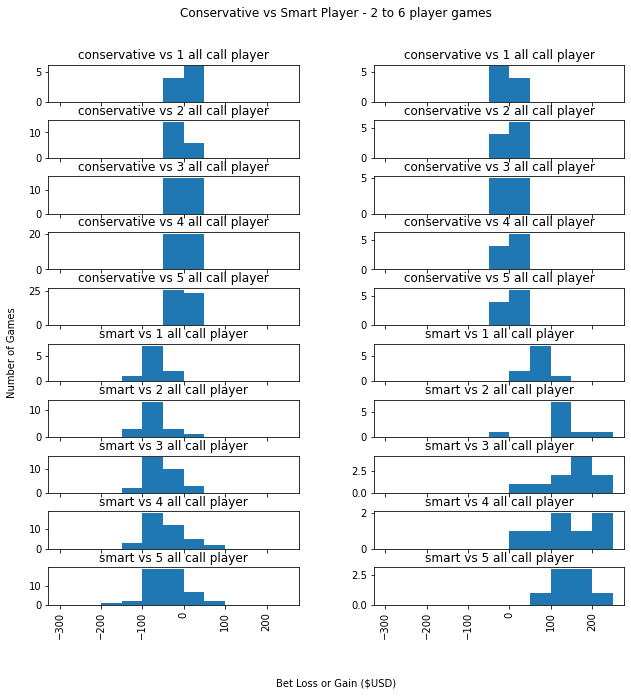

In [9]:
fig, axis = plt.subplots(10,2,figsize=(10, 10), sharex = True)

table_level_statistics.hist(
        column='table_mean',
        by=['scenario_name','player_type'],
        grid = True,
        bins = list(range(-300,300,50)),
        ax = axis
)

for row in axis:
    for col in row:
        col.set_title(col.title.get_text().split(',')[0][1:])

fig.text(0.5,0.04, "Bet Loss or Gain ($USD)", ha="center", va="center")
fig.text(0.05,0.5, "Number of Games", ha="center", va="center", rotation=90)

plt.suptitle("Conservative vs Smart Player - 2 to 6 player games")



We can also look at the mean, variance and standard deviation of players across all games within a scenario.  Sometimes interesting patterns emerge.

In [10]:
game_level_statistics = games.groupby(['category','scenario_name','player_name','player_type']).agg({
    "game_net_change":[np.mean,lambda col: np.var(col,ddof=1)],
    "game_end_balance":[np.min,np.max]
}).reset_index().sort_values(['player_name'])

game_level_statistics.columns = ['category','scenario_name','player_name','player_type','game_mean','game_variance','min_balance','max_balance']

game_level_statistics.sort_values(['scenario_name','player_name'])

,category,scenario_name,player_name,player_type,game_mean,game_variance,min_balance,max_balance
0,conservative,conservative vs 1 all call player,players_1,ConservativePlayer,-0.310000,94.698599,99790.000000,100230.000000
1,conservative,conservative vs 1 all call player,players_2,AlwaysCallPlayer,0.310000,94.698599,99770.000000,100210.000000
2,conservative,conservative vs 2 all call player,players_1,ConservativePlayer,0.375000,195.730105,99850.000000,100240.000000
3,conservative,conservative vs 2 all call player,players_2,AlwaysCallPlayer,-0.255000,189.499474,99815.000000,100160.000000
4,conservative,conservative vs 2 all call player,players_3,AlwaysCallPlayer,-0.120000,191.577177,99715.000000,100185.000000
5,conservative,conservative vs 3 all call player,players_1,ConservativePlayer,0.286667,290.764142,99813.333333,100293.333333
6,conservative,conservative vs 3 all call player,players_2,AlwaysCallPlayer,-0.373333,279.495673,99710.000000,100333.333333
7,conservative,conservative vs 3 all call player,players_3,AlwaysCallPlayer,0.660000,297.528595,99820.000000,100490.000000
8,conservative,conservative vs 3 all call player,players_4,AlwaysCallPlayer,-0.573333,276.102947,99590.000000,100300.000000
9,conservative,conservative vs 4 all call player,players_1,ConservativePlayer,0.310000,388.859426,99696.666667,100280.000000


After taking out bets between -25 and 25, we look at the distribution of tails to see if anything interesting occurs.  We can note that for Smart Player, he tends to lose about as often as the Always Call Player.  That said, when Smart Player wins he tends to win by a lot.  This I think is due to the fact that he raises $100 when he thinks he has a 75 percent chance of winning.  He might do this muliple times in a round if he is certain of a win.

Text(0.5, 0.98, 'Conservative vs Smart Player - 2 to 6 player games')

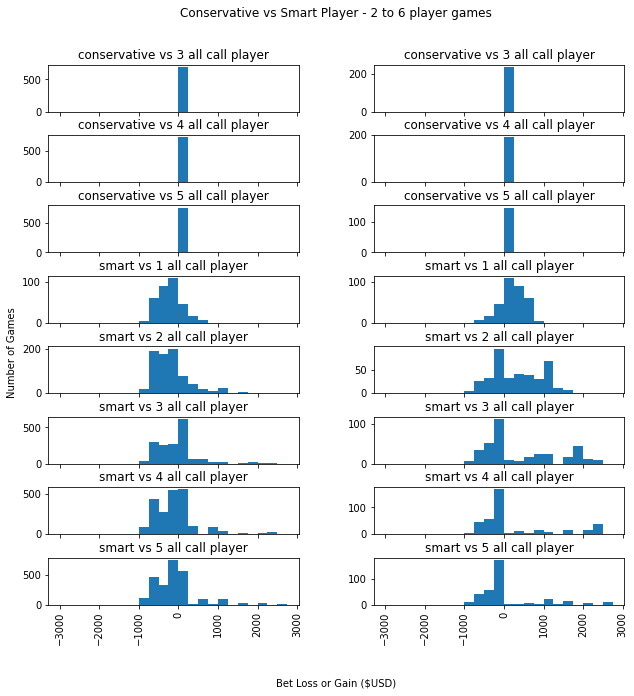

In [11]:
fig, axis = plt.subplots(8,2,figsize=(10, 10), sharex = True)

games.query('game_net_change < -25 or game_net_change > 25').hist(
        column='game_net_change',
        by=['scenario_name','player_type'],
        grid = True,
        bins = list(range(-3000,3000,250)),
        ax = axis
)

for row in axis:
    for col in row:
        col.set_title(col.title.get_text().split(',')[0][1:])

fig.text(0.5,0.04, "Bet Loss or Gain ($USD)", ha="center", va="center")
fig.text(0.05,0.5, "Number of Games", ha="center", va="center", rotation=90)

plt.suptitle("Conservative vs Smart Player - 2 to 6 player games")



The overall game end balance is sequential, so it's a bit misleading to graph it as a box plot since each observation is not independent.  That said, the patterns in the distributions of end balances do have interesting properties in terms of ranges, mean and quartile that create an interesting observation.  Smart player's average is higher than 75% quantile of the All Call Players with the bottom of his range being about as bad as the mean of the all call players.  Smart playres end balance has significant amount of outliers sometimes 30% or more from the starting balanace.  The end balance for all call player tends to be lower, but not so drastic as the smart player.  partially due to the fact that in multiplayer games, Smart player can collect from many Always call players mitigating the damage.

[Text(1, 0, 'always call player - conservative scenario'),
 Text(2, 0, 'always call player - smart scenario'),
 Text(3, 0, 'conservative player - conservative scenario'),
 Text(4, 0, 'smart player - smart scenario')]

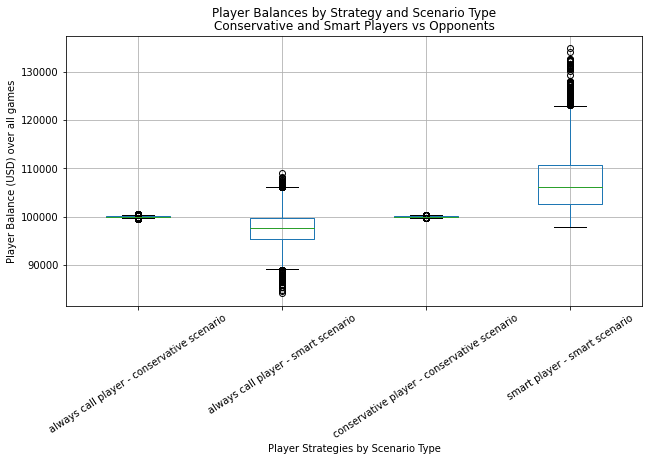

In [12]:
axis = games.boxplot(
        column=['game_end_balance'],
        by=['player_type','category'],
        figsize=(10,5),
        rot=33
)

plt.suptitle("Player Balances by Strategy and Scenario Type")
axis.set_title('Conservative and Smart Players vs Opponents')
axis.set_ylabel('Player Balance (USD) over all games')
axis.set_xlabel('Player Strategies by Scenario Type')

axis_replace={
    'AlwaysCallPlayer': 'always call player',
    'SmartPlayer': 'smart player',
    'ConservativePlayer': 'conservative player'
}

axis_cat_labels = [ax.get_text()[1:-1].split(',') for ax in axis.get_xmajorticklabels()]
axis_cat_labels = [axis_replace[ax[0]] + ' -' + ax[1] + ' scenario' for ax in axis_cat_labels]
axis.set_xticklabels(axis_cat_labels)


# Performance of Player Balances over Time

We provide the time series we used for the player balance over 100 games.  We included all 10 scenarios here.  The game_id is mapped sequentially from 1-100.  Table id is uniquely mapped as well.  On average, the player balance for smart player increases dramatically at the expense of all call players.

In [13]:
time_series = games[['category','scenario_name','player_name','player_type','table_id','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100
time_series['table_id'] = (time_series['table_id'] - 1) % 10
time_series = time_series.pivot_table(index=['category','scenario_name','player_name','player_type','table_id'],columns=['game_id'],values='game_end_balance').reset_index()
time_series

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


game_id,category,scenario_name,player_name,player_type,table_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,conservative,conservative vs 1 all call player,players_1,ConservativePlayer,0,99990.0,100000.0,99990.000000,99980.000000,99970.000000,99980.000000,99990.000000,100000.000000,100010.000000,100020.000000,100030.000000,100040.000000,100030.000000,100020.000000,100030.000000,100040.000000,100030.000000,100020.000000,100010.000000,100020.000000,100020.000000,100010.000000,100020.000000,100010.000000,100010.000000,100000.000000,100010.000000,100000.000000,99990.000000,99980.000000,99990.000000,100000.000000,100010.000000,100000.000000,99990.000000,99980.000000,99990.000000,99980.000000,99970.000000,99980.000000,99990.000000,99980.000000,99970.000000,99980.000000,99970.000000,99980.000000,99990.000000,100000.000000,100010.000000,100020.000000,100030.000000,100040.000000,100050.000000,100060.000000,100050.000000,100060.000000,100050.000000,100060.000000,100070.000000,100060.000000,100050.000000,100040.000000,100050.000000,100060.000000,100070.000000,100080.000000,100090.000000,100100.000000,100110.000000,100120.000000,100110.000000,100120.000000,100110.000000,100120.000000,100110.000000,100100.000000,100110.000000,100120.000000,100110.000000,100120.000000,100110.000000,100100.000000,100110.000000,100120.000000,100130.000000,100120.000000,100110.000000,100100.000000,100110.000000,100100.000000,100110.000000,100120.000000,100130.000000,100140.000000,100130.000000,100120.000000,100130.000000,100120.000000,100110.000000,100100.000000
1,conservative,conservative vs 1 all call player,players_1,ConservativePlayer,1,100010.0,100000.0,99990.000000,99990.000000,99980.000000,99990.000000,99980.000000,99990.000000,99980.000000,99980.000000,99990.000000,99980.000000,99970.000000,99960.000000,99950.000000,99940.000000,99930.000000,99920.000000,99920.000000,99910.000000,99920.000000,99930.000000,99940.000000,99930.000000,99940.000000,99950.000000,99960.000000,99950.000000,99940.000000,99950.000000,99960.000000,99950.000000,99940.000000,99950.000000,99960.000000,99950.000000,99960.000000,99950.000000,99940.000000,99930.000000,99940.000000,99950.000000,99960.000000,99970.000000,99980.000000,99990.000000,99980.000000,99990.000000,99980.000000,99990.000000,99980.000000,99970.000000,99960.000000,99970.000000,99960.000000,99950.000000,99940.000000,99950.000000,99940.000000,99940.000000,99930.000000,99940.000000,99950.000000,99940.000000,99930.000000,99930.000000,99940.000000,99930.000000,99920.000000,99930.000000,99940.000000,99930.000000,99940.000000,99930.000000,99940.000000,99950.000000,99940.000000,99950.000000,99960.000000,99950.000000,99940.000000,99930.000000,99920.000000,99910.000000,99920.000000,99910.000000,99900.000000,99910.000000,99900.000000,99910.000000,99900.000000,99900.000000,99890.000000,99900.000000,99890.000000,99900.000000,99910.000000,99900.000000,99910.000000,99900.000000
2,conservative,conservative vs 1 all call player,players_1,ConservativePlayer,2,99990.0,100000.0,99990.000000,100000.000000,100010.000000,100000.000000,99990.000000,100000.000000,99990.000000,99980.000000,99990.000000,100000.000000,100000.000000,100010.000000,100000.000000,99990.000000,99980.000000,99990.000000,99980.000000,99970.000000,99960.000000,99970.000000,99960.000000,99950.000000,99960.000000,99950.000000,99940.000000,99930.000000,99920.000000,99920.000000,99930.000000,99930.000000,99940.000000,99930.000000,99920.000000,99930.000000,99940.000000,99950.000000,99940.000000,99950.000000,99940.000000,99940.000000,99930.000000,99920.000000,99910.000000,99900.000000,99890.000000,99900.000000,99910.000000,99900.000000,99910.000000,99900.000000,99910.000000,99920.000000,99920.000000,99930.000000,99920.000000,99910.

Below we provide per game confidence intervals for each player in each scenario category: conservative vs smart player.  Here you can look into the data about how poker players did relatively to the number of games played.

In [14]:
time_series = games[['category','player_type','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100
time_series_stats = time_series.groupby(['category','player_type','game_id']).agg(
    {'game_end_balance':[
        ['mean',np.mean],
        ['sample_var',lambda col: np.var(col,ddof=1)],
        ['N','count']]
    }
).reset_index()

time_series_stats.columns = ['category','player_type','game_id','mean','sample_var','N']
time_series_stats['confidence_interval'] = time_series_stats.apply(lambda df: scistats.norm.interval(alpha=.95, loc=df['mean'],scale=np.sqrt(df['sample_var'])/np.sqrt(df['N'])),axis=1)
time_series_stats['lower_bound_95%'], time_series_stats['upper_bound_95%'] = zip(*time_series_stats.confidence_interval)
time_series_stats.pop('confidence_interval')
time_series_stats

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,category,player_type,game_id,mean,sample_var,N,lower_bound_95%,upper_bound_95%
0,conservative,AlwaysCallPlayer,0,100000.466667,3.504519e+02,150,99997.470840,100003.462493
1,conservative,AlwaysCallPlayer,1,100000.933333,6.984519e+02,150,99996.704012,100005.162655
2,conservative,AlwaysCallPlayer,2,99999.155556,9.958519e+02,150,99994.105457,100004.205654
3,conservative,AlwaysCallPlayer,3,99999.122222,1.296857e+03,150,99993.359224,100004.885220
4,conservative,AlwaysCallPlayer,4,99999.155556,1.599431e+03,150,99992.755478,100005.555633
5,conservative,AlwaysCallPlayer,5,99998.988889,2.108460e+03,150,99991.640618,100006.337160
6,conservative,AlwaysCallPlayer,6,99998.066667,2.594858e+03,150,99989.914760,100006.218574
7,conservative,AlwaysCallPlayer,7,99997.533333,2.849542e+03,150,99988.990735,100006.075932
8,conservative,AlwaysCallPlayer,8,99997.666667,3.347054e+03,150,99988.408311,100006.925022
9,conservative,AlwaysCallPlayer,9,99995.777778,3.550286e+03,150,99986.242483,100005.313073


This graphic shows you the mean balance between all player classes within the conservative and smart player types as well as the 95th confidence interval for ending player balance over time.  As you can see, Smart Player does well at the expense of the all call players.  He seems to do so at a relatively consistent rate.

c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


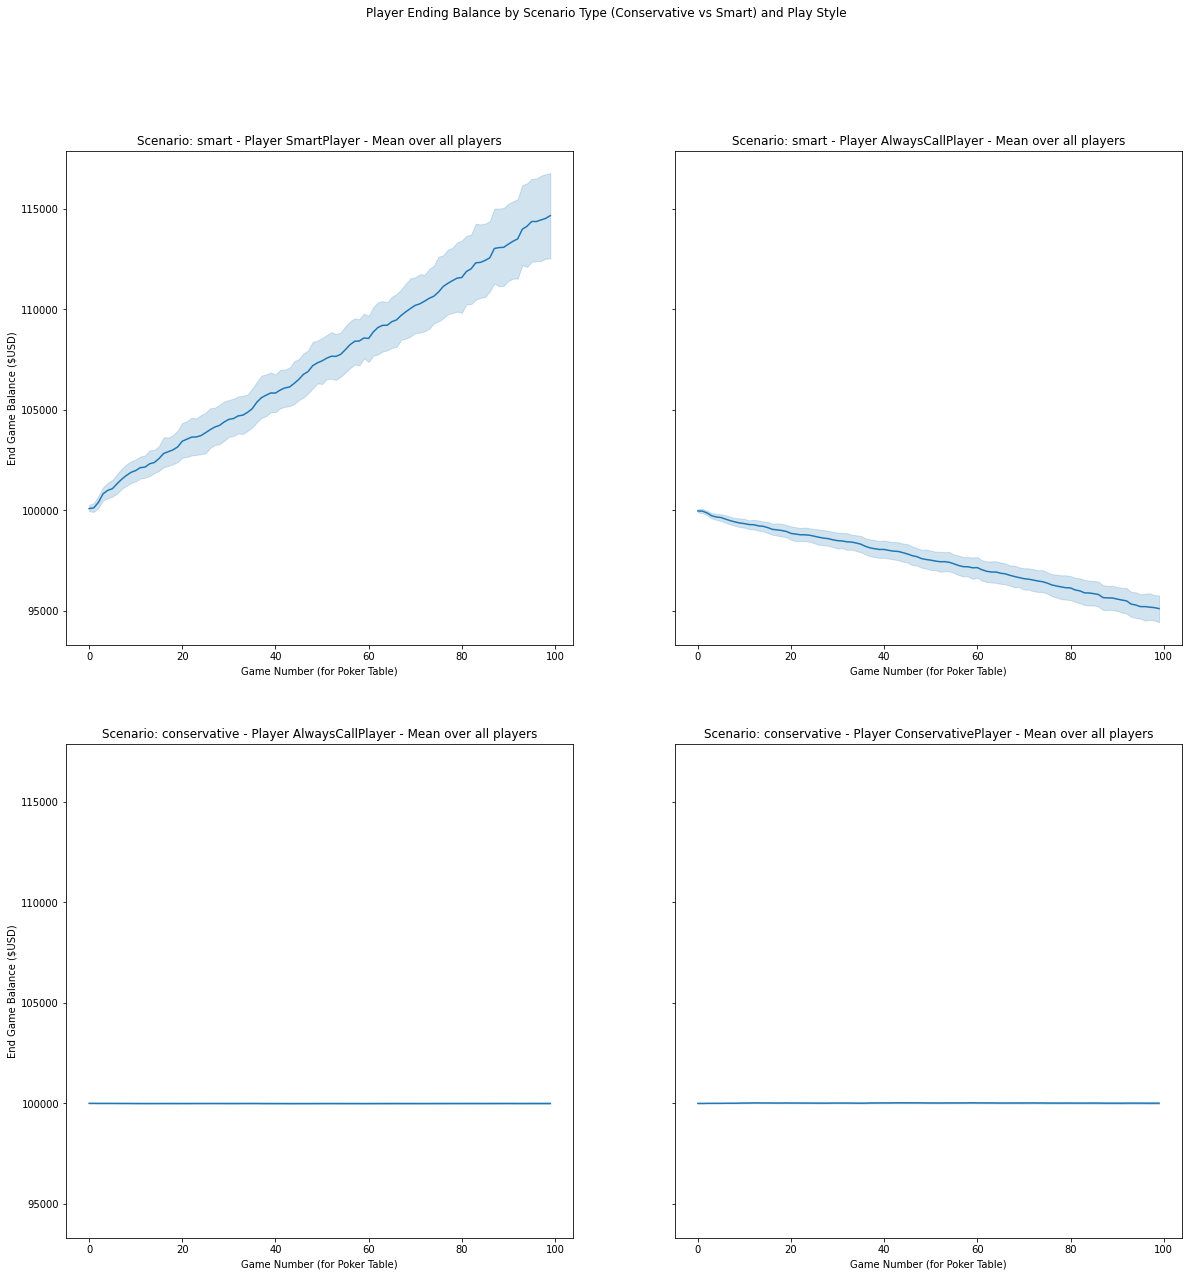

In [15]:
fig, axis = plt.subplots(2,2,figsize=(20, 20),sharey=True)

time_series = games[['category','player_type','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)
        
        
categories_to_plot = time_series[['category','player_type']].drop_duplicates()

plt.suptitle('Player Ending Balance by Scenario Type (Conservative vs Smart) and Play Style')
        
plot_num = 0
for index, row in categories_to_plot.iterrows():
    ax = all_axis[plot_num]
    plot_num += 1
    player_type, category = row['player_type'], row['category']
    query_filter = 'player_type == "{}" and category == "{}"'.format(player_type,category)
    plot_data = time_series.query(query_filter)
    sns.lineplot(x=plot_data['game_id'],y=plot_data['game_end_balance'],ax=ax)
    ax.set_title('Scenario: {} - Player {} - Mean over all players'.format(category,player_type))
    ax.set_ylabel('End Game Balance ($USD)')
    ax.set_xlabel('Game Number (for Poker Table)')



c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


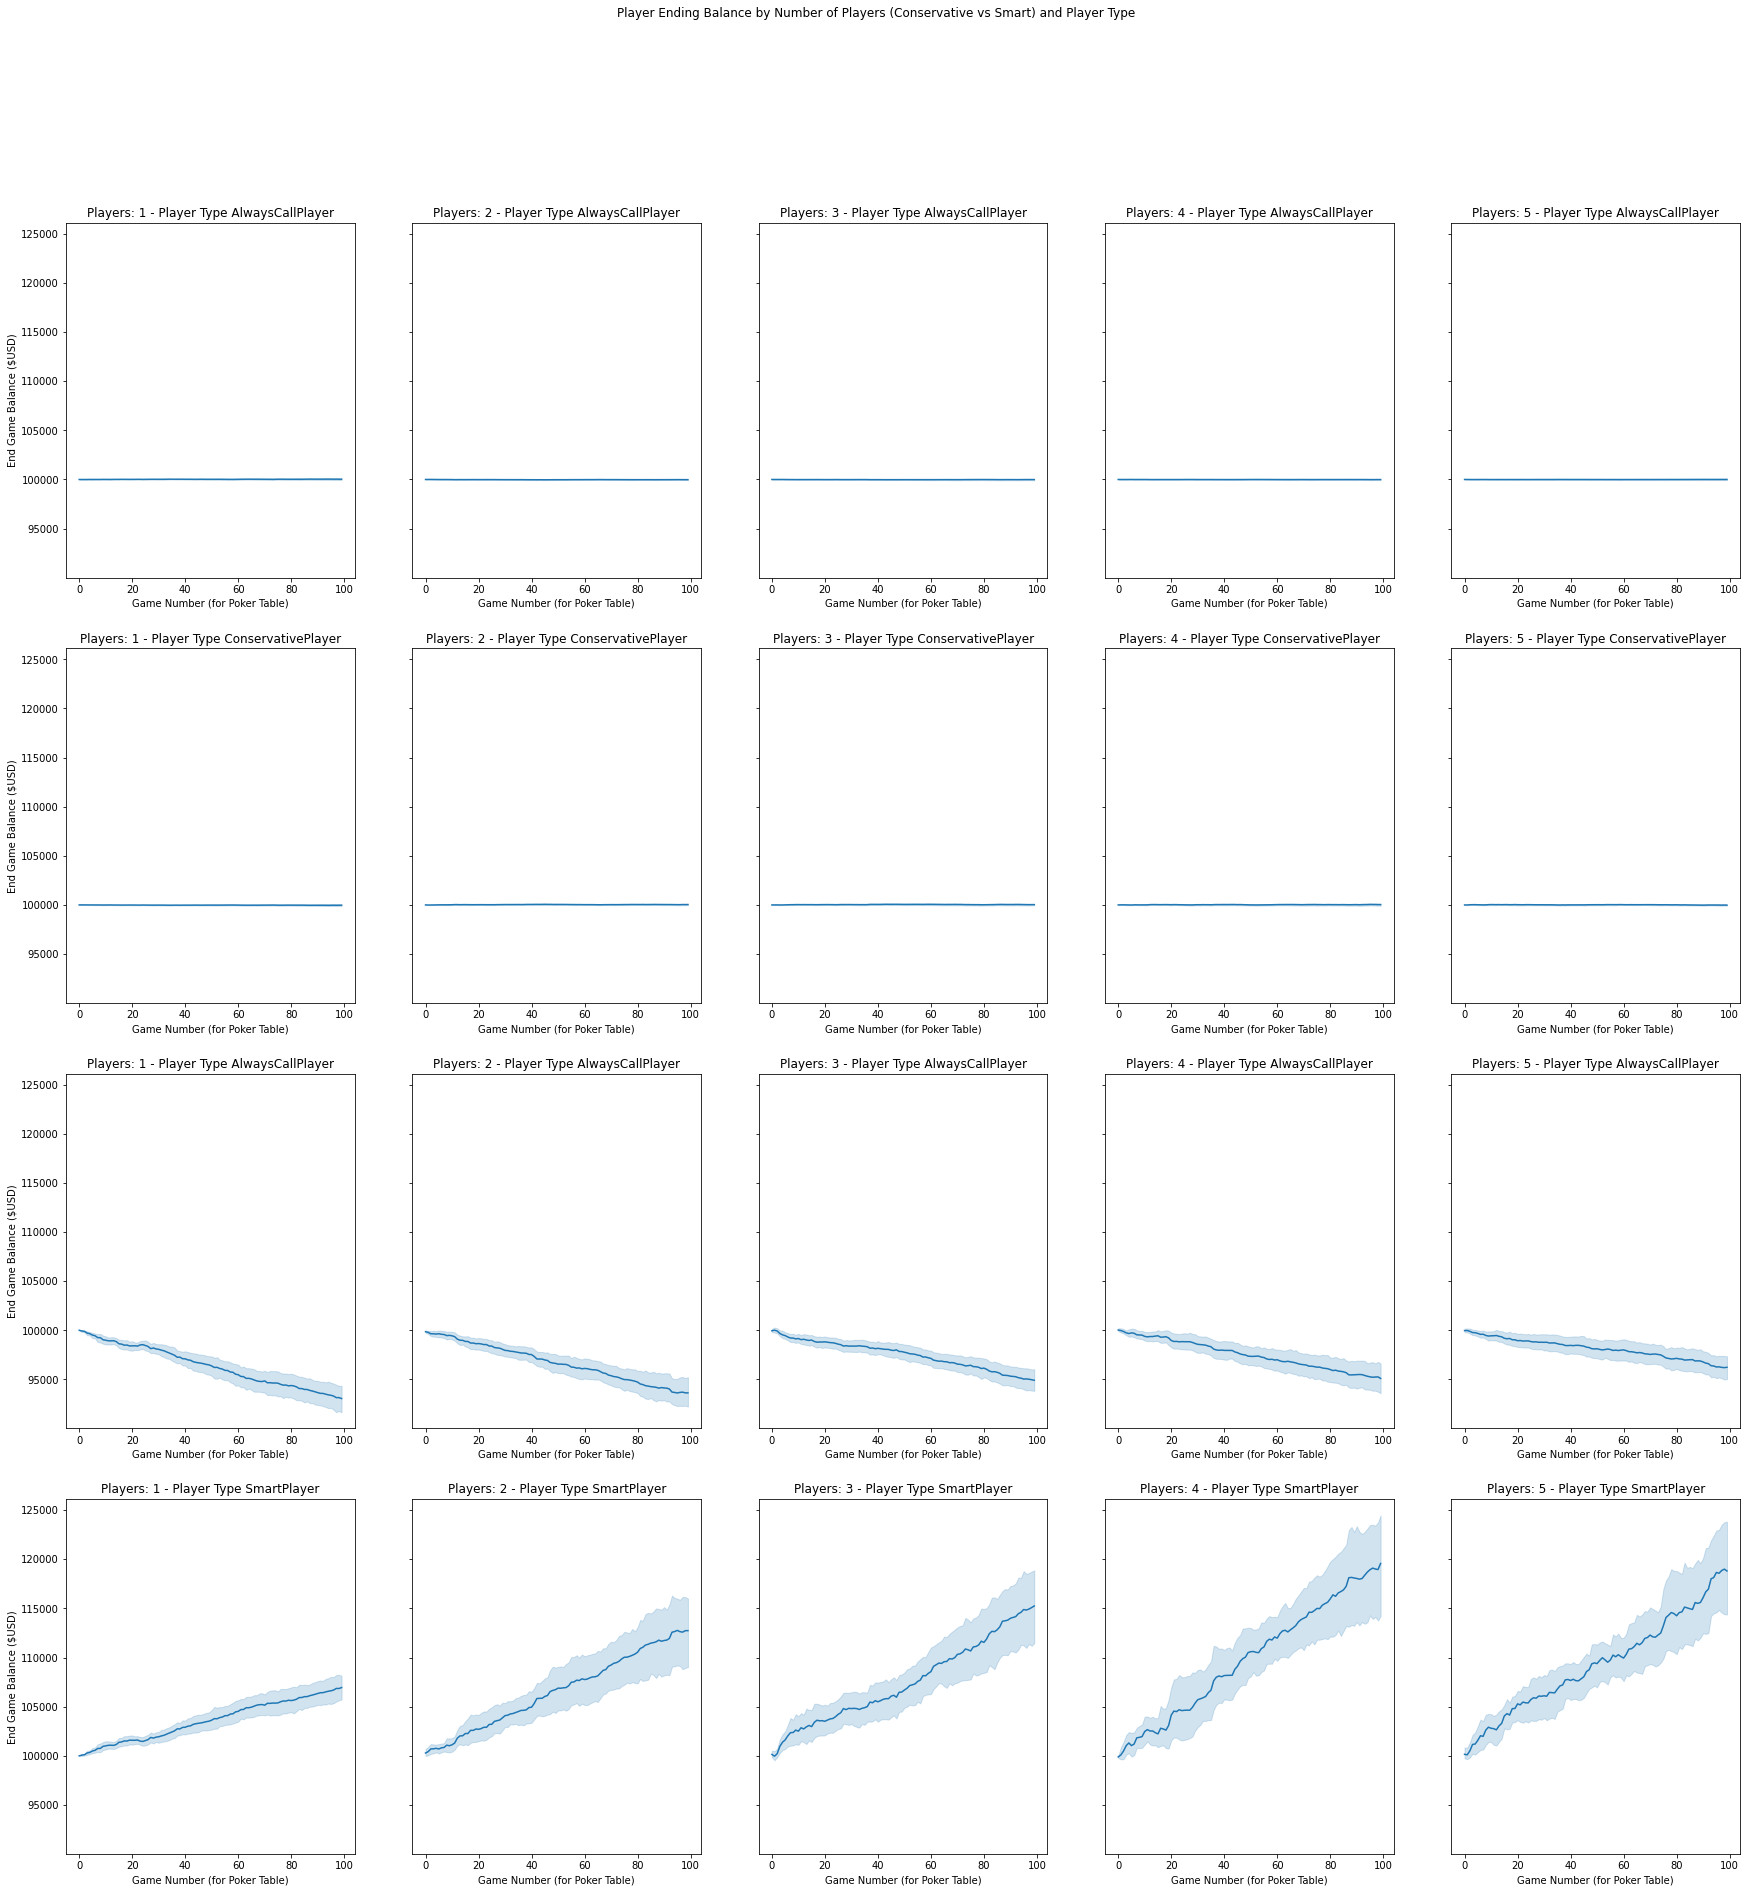

In [17]:
fig, axis = plt.subplots(4,5,figsize=(30, 30),sharey=True)

time_series = games[['category','scenario_name','player_type','game_id','game_end_balance']]
time_series['game_id'] = (time_series['game_id'] - 1) % 100

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)
        
categories_to_plot = time_series[['category','scenario_name','player_type']].drop_duplicates()
categories_to_plot['sort_order'] =  categories_to_plot.scenario_name.str.extract('(\d+)')
categories_to_plot = categories_to_plot.sort_values(['category','player_type','sort_order'])
plt.suptitle('Player Ending Balance by Number of Players (Conservative vs Smart) and Player Type')
    
plot_num = 0
for index, row in categories_to_plot.iterrows():
    ax = all_axis[plot_num]
    plot_num += 1
    player_type, category, scenario_name, number = row['player_type'], row['category'], row['scenario_name'], row['sort_order']
    query_filter = 'player_type == "{}" and category == "{}" and scenario_name == "{}"'.format(player_type,category,scenario_name)
    plot_data = time_series.query(query_filter)
    sns.lineplot(x=plot_data['game_id'],y=plot_data['game_end_balance'],ax=ax)
    ax.set_title('Players: {} - Player Type {}'.format(number,player_type))
    ax.set_ylabel('End Game Balance ($USD)')
    ax.set_xlabel('Game Number (for Poker Table)')


# Analysis of End Game Results

,player_type,game_result,game_reason,final_hand,game_net_change
0,SmartPlayer,lost,lost_game,one_pair,-10.0
1,SmartPlayer,won,won_game,one_pair,10.0
2,SmartPlayer,won,won_game,straight,210.0
3,SmartPlayer,lost,fold,straight,-10.0
4,SmartPlayer,won,won_game,full_house,110.0
...,...,...,...,...,...
39995,AlwaysCallPlayer,lost,lost_game,one_pair,-10.0
39996,AlwaysCallPlayer,lost,lost_game,one_pair,-10.0
39997,AlwaysCallPlayer,lost,lost_game,high_card,-10.0
39998,AlwaysCallPlayer,lost,lost_game,one_pair,-10.0


# Analysis of 2 Card Games, Flob and River performance

In [190]:
pre_flop_hands = hands.query('community1 == "Z-N/A" and bet_number == "1"')
analysis_data = pre_flop_hands[['category','player_type','opponents','hand1','hand2','game_reason','game_net_change']]
analysis_data[['rank1', 'suit1']] = analysis_data['hand1'].str.split('-', 1, expand=True)
analysis_data[['rank2', 'suit2']] = analysis_data['hand2'].str.split('-', 1, expand=True)
analysis_data['same_suit'] = analysis_data['rank1'] == analysis_data['rank2']
analysis_data

C:\Users\Silbe\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
c:\users\silbe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,category,player_type,opponents,hand1,hand2,game_reason,game_net_change,rank1,suit1,rank2,suit2,same_suit
0,smart,SmartPlayer,1,4-diamonds,Q-diamonds,lost_game,-10.0,4,diamonds,Q,diamonds,False
4,smart,SmartPlayer,1,J-spades,Q-hearts,won_game,10.0,J,spades,Q,hearts,False
8,smart,SmartPlayer,1,8-hearts,9-hearts,won_game,210.0,8,hearts,9,hearts,False
12,smart,SmartPlayer,1,5-diamonds,6-diamonds,fold,-10.0,5,diamonds,6,diamonds,False
14,smart,SmartPlayer,1,7-clubs,7-diamonds,won_game,110.0,7,clubs,7,diamonds,True
...,...,...,...,...,...,...,...,...,...,...,...,...
177798,conservative,AlwaysCallPlayer,5,3-clubs,K-hearts,lost_game,-10.0,3,clubs,K,hearts,False
177802,conservative,AlwaysCallPlayer,5,2-spades,5-clubs,lost_game,-10.0,2,spades,5,clubs,False
177806,conservative,AlwaysCallPlayer,5,6-clubs,K-hearts,lost_game,-10.0,6,clubs,K,hearts,False
177810,conservative,AlwaysCallPlayer,5,3-clubs,A-diamonds,lost_game,-10.0,3,clubs,A,diamonds,False


<AxesSubplot:>

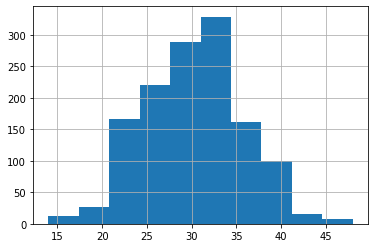

In [191]:
analysis_data.groupby(['hand1','hand2']).game_reason.count().hist()

In [192]:
per_game_type = analysis_data.groupby(['rank1','rank2','same_suit','game_reason']).category.count().reset_index()
games_total = analysis_data.groupby(['rank1','rank2','same_suit']).game_net_change.count().reset_index()
pre_flop_data = pd.merge(per_game_type,games_total).sort_values(['rank1','rank2','same_suit'])

In [193]:
game_stats = pre_flop_data.pivot(index =['rank1','rank2','same_suit','game_net_change'], columns = ['game_reason'], values =['category']).reset_index()
game_stats.columns = [c[1] if c[1] else c[0] for c in game_stats.columns]
game_stats = game_stats.fillna(0)
game_stats['fold_percent'] = round(100 * game_stats['fold'] / game_stats['game_net_change'],0)
game_stats['last_man_standing_percent'] = round(100 * game_stats['last_man_standing'] / game_stats['game_net_change'],0)
game_stats['lost_game_percent'] = round(100 * game_stats['lost_game'] / game_stats['game_net_change'],0)
game_stats['won_game_percent'] = round(100 * game_stats['won_game'] / game_stats['game_net_change'],0)

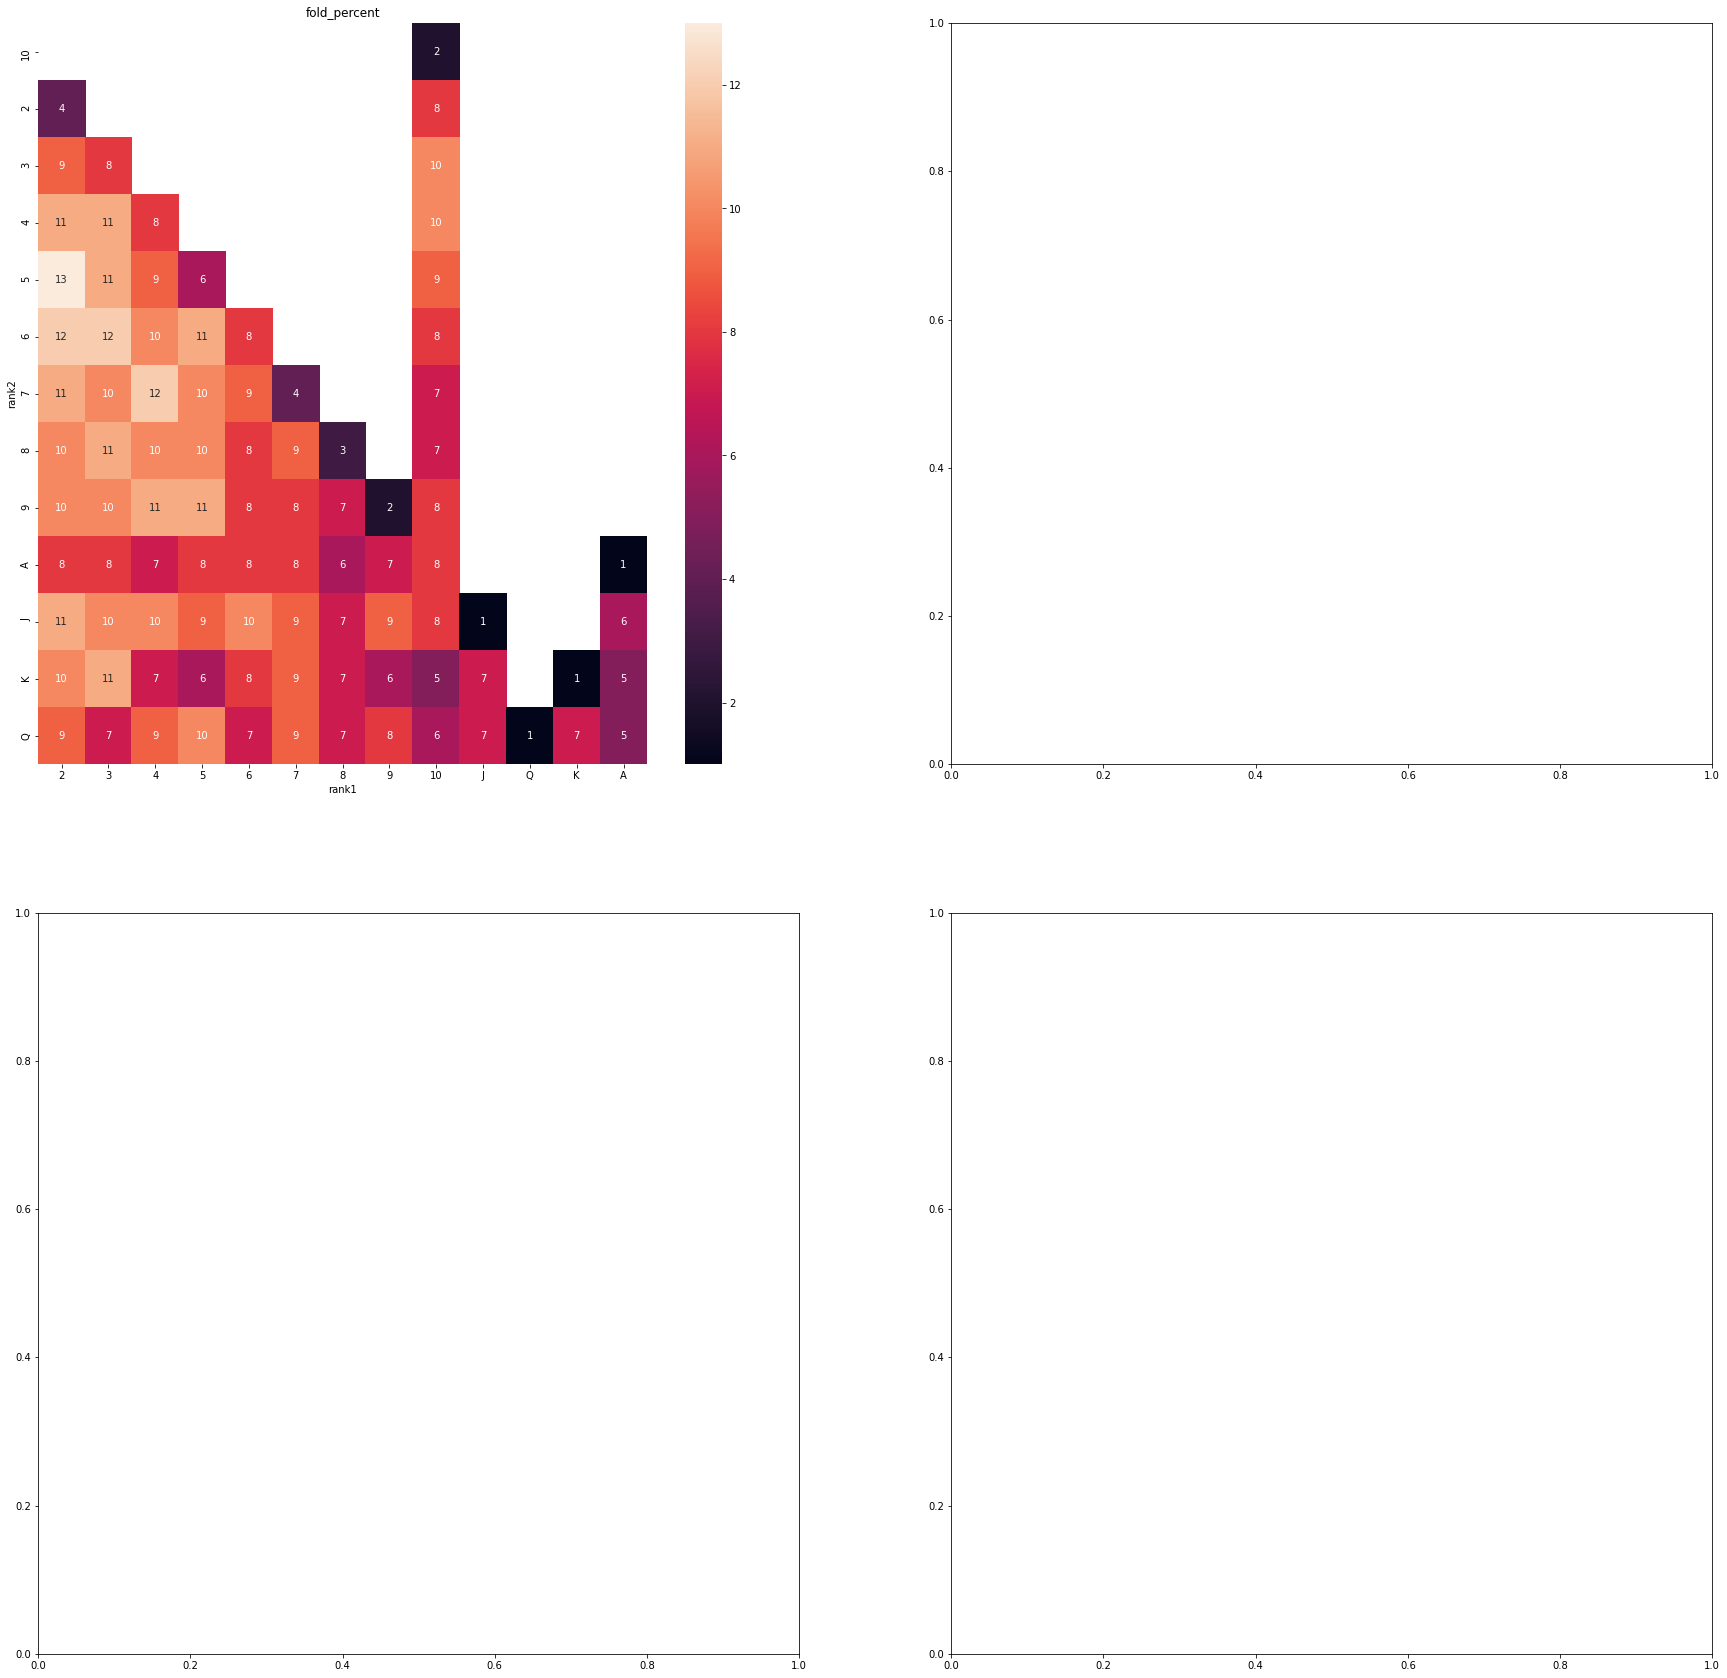

In [213]:
fig, axis = plt.subplots(2,2,figsize=(30, 30))

percentages = game_stats[['rank1','rank2','same_suit'] + [c for c in game_stats.columns if c.endswith('percent')]].sort_values(['won_game_percent','last_man_standing_percent','fold_percent','lost_game_percent'],ascending=False)

all_axis = []

for row in axis:
    for col in row:
        all_axis.append(col)
        
rank_order = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']

plot_num = 0
for percent in [c for c in percentages.columns if c.endswith('percent')]:
    ax = all_axis[plot_num]
    percents_pivot = percentages.pivot(index='rank2',columns='rank1',values=percent)
    percents_pivot = percents_pivot.loc[:,rank_order]
    sns.heatmap(percents_pivot, annot = True, ax = ax)
    ax.set_title(percent)
    plot_num += 1
    break

In [212]:
percentages

,rank1,rank2,same_suit,fold_percent,last_man_standing_percent,lost_game_percent,won_game_percent
81,A,A,True,1.0,1.0,37.0,61.0
88,K,K,True,1.0,2.0,37.0,60.0
90,Q,Q,True,1.0,0.0,43.0,56.0
85,J,J,True,1.0,0.0,48.0,51.0
76,9,9,True,2.0,1.0,48.0,49.0
70,8,8,True,3.0,1.0,51.0,45.0
0,10,10,True,2.0,0.0,54.0,45.0
84,A,Q,False,5.0,1.0,51.0,43.0
82,A,J,False,6.0,1.0,53.0,39.0
83,A,K,False,5.0,1.0,56.0,38.0
